In [1]:
## import libraries
import os
from os import listdir
from os.path import isfile, join

import pandas as pd
from itertools import islice
import numpy as np

from skimage.external import tifffile
from skimage.external.tifffile import imread

import matplotlib.pyplot as plt

import ipywidgets as widgets

import random


from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor

from scipy import ndimage
from PIL import Image, ImageDraw

import numpy.ma as ma

from skimage.measure import label, regionprops

In [2]:
bigDir=r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [3]:
newfile=f'{bigDir}\\new dataset\cellinfo_signals_v3.csv'
newdata=pd.read_csv(newfile)

In [7]:
orgfile=f'{bigDir}\\csv_signals_cell_data\\signal_data_total_v3.csv'
orgdata=pd.read_csv(orgfile)

In [ ]:
file=f'{bigDir}\\cellinfo_200203_v2.csv'
data=pd.read_csv(file)

# creating nuclear masks
run r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\jupyter_scripts\MCM_project\batchMCMsegm_nucleus.ijm.ijm'

# creating erosion inner and outer masks

In [2]:
nine_filter=skmor.ball(1)
radius=1
while (nine_filter.shape[0]<9):
    radius+=1
    nine_filter=skmor.ball(radius)
nine_filter=np.delete(nine_filter, [(0,1,2,6,7,8)], axis=0)

In [44]:
def create_erosion_nuc_masks(name,data):
    
    ## checking if the data given is new or original dataset
    if name=="new":
        hp1=1
    else:
        hp1=0
    
    i=0
    # Progress Bar for the function
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)
    
    ## creating the structure/filter with 9x9x9 
    nine_filter=skmor.ball(1)
    radius=1
    while (nine_filter.shape[0]<9):
        radius+=1
        nine_filter=skmor.ball(radius)
    ### only using the middle 3 layers of the cube (3x9x9)
    nine_filter=np.delete(nine_filter, [(0,1,2,6,7,8)], axis=0)
    
    ## creating masks for entire cells in the dataset
    for i,cell in islice(data.iterrows(),i,None):
        percentile = 20

        ## open tiff image of a cell
        ### if the file is not found in the directory, trying to change the file extension 
        #### this is because there are some file files that are saved as tiff image 
        try:
            myImage=imread(cell.path) 
        except:
            cell.path=cell.path.replace('.tif','.tiff')
            myImage=imread(cell.path)
        
        ## open nucleus mask
        ### if the file is not found in the directory, trying to change the file extension 
        #### this is because there are some file files that are saved as tiff image 
        nucleusMaskPath=cell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
        nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
        try:
            nucMask=imread(nucleusMaskPath)
        except:
            nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
            nucMask=imread(nucleusMaskPath)

        ## making nucleus mask binary 
        nucMask=nucMask.astype(bool)

        ## using the pre-made filter for morphology (erosion) 
        copy_nuc=nucMask.copy()
        ### inner mask (iterating 3x9x9 structure 5 times)
        nin_fiv=br(nucMask, structure=nine_filter, iterations=5)
        ### deselecting the inner mask from the nucleus mask, creating outer nucleus mask
        outermask=nucMask.copy()
        outermask[nin_fiv]=0
        
        ## saving image files
        newSegFolder = os.path.dirname(cell.path).replace('data_tiff','erosion_nuc_mask')
        try:
            os.mkdir(newSegFolder)
        except:
            pass
        maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_9^5_inner_mask_{percentile}.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), nin_fiv.astype('uint8'))
        maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_9^5_outer_mask_{percentile}.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), outermask.astype('uint8'))
        
        progBar.value=progBar.value+1


In [43]:
create_erosion_nuc_masks("new",newdata)

IntProgress(value=0, description='Progress:', max=324)

In [46]:
create_erosion_nuc_masks("org",orgdata)

IntProgress(value=0, description='Progress:', max=300)

In [ ]:
create_erosion_nuc_masks("new",data)

# creating heterochromatin masks - 20% brightest pixel

In [52]:
def create_het_mask(name,data):
    ## based on the name give as a parameter, selecting the channel 
    ### hp1beta channel is 2 in new dataset and 1 in original dataset
    if name=="new":
        hp1=1
    else:
        hp1=0
    
    
    
    ## calculating 20% brightest pixles
    het_percentile=20
    
    # Progress Bar
    i=0
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(data.iterrows(), i,None):

        ## create folder to store this percentile data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_{het_percentile}')
        newResultsFolder = os.path.dirname(myCell.path).replace('data_tiff', 'results')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        try:
            os.mkdir(newResultsFolder)
        except:
            pass


        ## open tiff image of a cell
        try:
            myImage=imread(myCell.path)    
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    

        ## opening the channel according to the dataset
        myChannel = myImage[:, hp1, :, :] 

        ## open nucleus mask
        ### if the file is not found in the directory, trying to change the file extension 
        #### this is because there are some file files that are saved as tiff image 
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
        nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
        try:
            nucleusMask=imread(nucleusMaskPath)
        except:
            nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
            nucleusMask=imread(nucleusMaskPath)


        ## make nucleus mask binary
        nucleusMask = nucleusMask.astype(bool)

        ## clean image
        myNucleus = myChannel[nucleusMask]

        ## find threshold
        myPercentile = np.nanpercentile(myNucleus, (100-het_percentile)) 

        ## threshold
        myHetMask=np.zeros(myChannel.shape).astype('bool')
        myHetMask[myChannel >= myPercentile] = 1

        ## clean from elements outside the nucleus
        cleanNucleusMask=~nucleusMask
        myHetMask[cleanNucleusMask]=0
        cleanHetMask = ~myHetMask

        ## save segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), myHetMask.astype('uint8'))


        progBar.value=progBar.value+1

        

In [53]:
create_het_mask("new", newdata)

IntProgress(value=0, description='Progress:', max=324)

In [54]:
create_het_mask("org", orgdata)

IntProgress(value=0, description='Progress:', max=300)

In [ ]:
create_het_mask("new", data)

# masking heterochromatin with inner and outer masks

In [86]:
def create_het_mask_erosion (name, data):
    if name=="new":
            hp1=1
    else:
        hp1=0

    i=0
    het_percentile=20
    # Progress Bar
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(data.iterrows(), i,None):

        # create folder to store this percentile (inner and outer) data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_{het_percentile}_erosion')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        try:
            os.mkdir(newResultsFolder)
        except:
            pass


        # open tiff image of a cell
        try:
            myImage=imread(myCell.path)    
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    


        myChannel = myImage[:, 1, :, :] #2nd channel is hetChrom (as stained by HP1B or H3K9Me3)

        ## openning nucleus masks
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','erosion_nuc_mask')
        nucouterpath=nucleusMaskPath.replace('.tif','_eroded_9^5_outer_mask_20.tif')
        nucinnerpath=nucleusMaskPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
        outernuc=imread(nucouterpath)
        outernuc=outernuc.astype(bool)
        innernuc=imread(nucinnerpath)
        innernuc=innernuc.astype(bool)

        ## opening heterochromatin mask
        hetPath=myCell.path
        hetPath=hetPath.replace('data_tiff','segmentation_20')
        hetPath=hetPath.replace('.tif','_hetChrom.tif')
        het=imread(hetPath)
        het=het.astype(bool)

        ## masking heterochromatin with inner nuc mask
        het_inner=het.copy()
        het_inner=het_inner.astype(bool)
        het_inner[~innernuc]=0

        ## masking heterochromatin with outer nuc mask
        het_outer=het.copy()
        het_outer=het_outer.astype(bool)
        het_outer[~outernuc]=0

        ## save segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom_inner.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), het_inner.astype('uint8'))
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom_outer.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), het_outer.astype('uint8'))


        progBar.value=progBar.value+1

    

In [87]:
create_het_mask_erosion("new",newdata)

IntProgress(value=0, description='Progress:', max=324)

In [88]:
create_het_mask_erosion("org",orgdata)

IntProgress(value=0, description='Progress:', max=300)

In [ ]:
create_het_mask_erosion("new",data)

# 200402 - recreating euchromatin mask

In [42]:
def create_eu_mask(name,data):
    ## based on the name give as a parameter, selecting the channel 
    ### hp1beta channel is 2 in new dataset and 1 in original dataset

    if name=="new":
        hp1=1
    else:
        hp1=0

    # Progress Bar
    i=0
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(data.iterrows(), i,None):

        ## create folder to store this percentile data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_{het_percentile}_eu')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        ## open tiff image of a cell
        try:
            myImage=imread(myCell.path)    
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    

        ## opening the channel according to the dataset
        myChannel = myImage[:, 1, :, :] 

        ## open nucleus mask
        ### if the file is not found in the directory, trying to change the file extension 
        #### this is because there are some file files that are saved as tiff image 
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
        nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
        try:
            nucleusMask=imread(nucleusMaskPath)
        except:
            nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
            nucleusMask=imread(nucleusMaskPath)

        hetPath=myCell.path
        hetPath=hetPath.replace('data_tiff','segmentation_20')
        hetPath=hetPath.replace('.tif','_hetChrom.tif')
        het=imread(hetPath)
        het=het.astype(bool)

        ## make nucleus mask binary
        nucleusMask = nucleusMask.astype(bool)

        ## clean image
        myNucleus = myChannel[nucleusMask]

        ## masking heterochromatin pixels out of nucleus - so total nucleus - heterochromatin = euchromatin
        myEuMask=np.zeros(myChannel.shape).astype('bool')
        myEuMask[nucleusMask]=1
        myEuMask[het]=0
        
        ## save segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_euChrom.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), myEuMask.astype('uint8'))
        

        progBar.value=progBar.value+1
        

In [43]:
create_eu_mask("new",newdata)

IntProgress(value=0, description='Progress:', max=324)

In [45]:
create_eu_mask("org",orgdata)

IntProgress(value=0, description='Progress:', max=300)

In [ ]:
create_eu_mask("new",data)

<IPython.core.display.Javascript object>


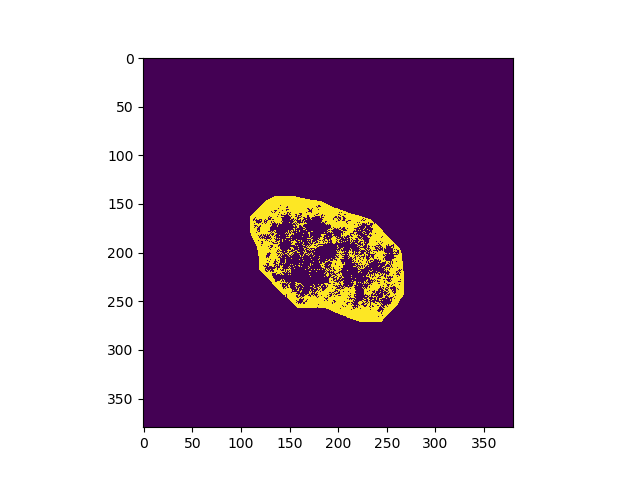

In [35]:
## tested with new data cell #1
%matplotlib notebook
myEuMask=np.zeros(myChannel.shape).astype('bool')
myEuMask[nucleusMask]=1
#myEuMask[cleanNucleusMask]=0
myEuMask[het]=0
plt.imshow(myEuMask[15])

<IPython.core.display.Javascript object>


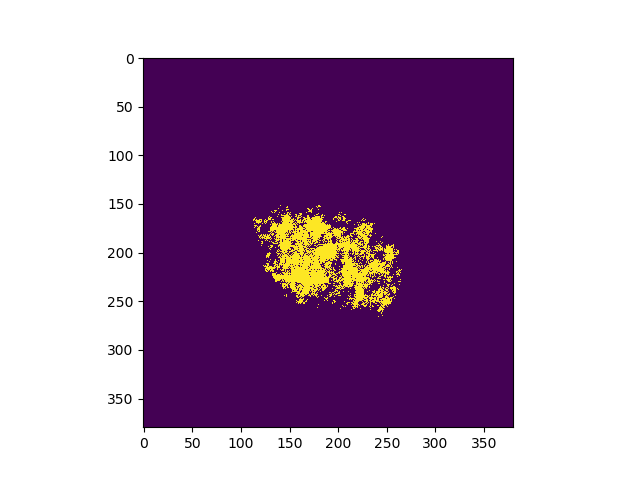

In [39]:
## tested with new data cell #1
%matplotlib notebook
plt.imshow(het[15])

In [38]:
# tested with new data cell #1
(np.sum(myEuMask)+np.sum(het)) / np.sum(nucleusMask)

1.0

# creating euchromatin inner and outer mask 

In [47]:
def create_eu_mask_erosion (name, data):
    if name=="new":
            hp1=1
    else:
        hp1=0

    i=0
    
    het_percentile=20
    eu_percentile=80
    
    # Progress Bar
    progBar=widgets.IntProgress(
        value=i,
        min=0,
        max=len(data),
        step=1,
        description='Progress:',
        orientation='horizontal'
    )
    display(progBar)

    for i,myCell in islice(data.iterrows(), i,None):

        # create folder to store this percentile (inner and outer) data if it doesn't exist yet
        newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_{het_percentile}_eu_erosion')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        try:
            os.mkdir(newResultsFolder)
        except:
            pass


        # open tiff image of a cell
        try:
            myImage=imread(myCell.path)    
        except:
            myCell.path=myCell.path.replace('.tif','.tiff')
            myImage=imread(myCell.path)    


        myChannel = myImage[:, 1, :, :] #2nd channel is hetChrom (as stained by HP1B or H3K9Me3)

        ## openning nucleus masks
        nucleusMaskPath=myCell.path
        nucleusMaskPath=nucleusMaskPath.replace('data_tiff','erosion_nuc_mask')
        nucouterpath=nucleusMaskPath.replace('.tif','_eroded_9^5_outer_mask_20.tif')
        nucinnerpath=nucleusMaskPath.replace('.tif','_eroded_9^5_inner_mask_20.tif')
        outernuc=imread(nucouterpath)
        outernuc=outernuc.astype(bool)
        innernuc=imread(nucinnerpath)
        innernuc=innernuc.astype(bool)

        ## opening heterochromatin mask
        euPath=myCell.path
        euPath=euPath.replace('data_tiff','segmentation_20_eu')
        euPath=euPath.replace('.tif','_euChrom.tif')
        eu=imread(euPath)
        eu=eu.astype(bool)

        ## masking heterochromatin with inner nuc mask
        eu_inner=eu.copy()
        eu_inner=eu_inner.astype(bool)
        eu_inner[~innernuc]=0

        ## masking heterochromatin with outer nuc mask
        eu_outer=eu.copy()
        eu_outer=eu_outer.astype(bool)
        eu_outer[~outernuc]=0

        ## save segmentation mask
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_euChrom_inner.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), eu_inner.astype('uint8'))
        maskFile = os.path.basename(myCell.path).replace('.tif',f'_euChrom_outer.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), eu_outer.astype('uint8'))


        progBar.value=progBar.value+1

    

In [48]:
create_eu_mask_erosion("new",newdata)

IntProgress(value=0, description='Progress:', max=324)

In [49]:
create_eu_mask_erosion("org",orgdata)

IntProgress(value=0, description='Progress:', max=300)

In [ ]:
create_eu_mask_erosion("new",data)